In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import time
import matplotlib.pyplot as plt

# Project utilities
from src.models import MLP
from src.metrics import OptimizationLogger
from src.reproducibility import set_seed
from src.utils import load_config


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


CUDA available: True


## Configuration Management

All hyperparameters (model size, optimizer settings, batch size, epochs, and seeds)
are loaded from an external YAML file to ensure reproducibility and fair benchmarking.


In [ ]:
cfg = load_config("configs/nn.yaml")

batch_size = cfg["training"]["batch_size"]
epochs = cfg["training"]["epochs"]
seeds = cfg["seeds"]

adam_cfg = cfg["optimizers"]["adam"]
adamw_cfg = cfg["optimizers"]["adamw"]


In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print("Using device:", device)

Using device: cuda


In [ ]:
# from src.models import MLP
# from src.metrics import OptimizationLogger
# from src.reproducibility import set_seed
# from src.utils import load_config


In [ ]:
# def set_seed(seed):
#     torch.manual_seed(seed)
#     np.random.seed(seed)


In [45]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


In [46]:
train_ds = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)


In [ ]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False)


In [ ]:
# class MLP(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.net = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(28*28, 128),
#             nn.ReLU(),
#             nn.Linear(128, 10)
#         )

#     def forward(self, x):
#         return self.net(x)


In [ ]:
# def train_one_epoch(model, loader, optimizer, criterion):
#     model.train()
#     total_loss = 0

#     for x, y in loader:
#         x, y = x.to(device), y.to(device)

#         optimizer.zero_grad()
#         out = model(x)
#         loss = criterion(out, y)
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()

#     return total_loss / len(loader)


def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    return correct / total



In [ ]:
def compute_grad_norm(model):
    total_norm = 0.0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    return total_norm ** 0.5


In [ ]:
# def run_experiment(optimizer_type, seed):
#     set_seed(seed)
#     model = MLP().to(device)
#     criterion = nn.CrossEntropyLoss()

#     if optimizer_type == "Adam":
#         optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
#     else:  # AdamW
#         optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

#     train_losses = []
#     test_accs = []

#     for epoch in range(10):
#         print("we are in epoch No : ",epoch)
#         loss = train_one_epoch(model, train_loader, optimizer, criterion)
#         acc = evaluate(model, test_loader)
#         train_losses.append(loss)
#         test_accs.append(acc)

#     return train_losses, test_accs


def run_experiment(optimizer_name, optimizer_cfg, seed):
    # Reproducibility
    set_seed(seed)

    # Model
    model = MLP(**cfg["model"]).to(device)
    criterion = nn.CrossEntropyLoss()

    # Optimizer
    if optimizer_name == "Adam":
        optimizer = optim.Adam(
            model.parameters(),
            lr=optimizer_cfg["lr"],
            weight_decay=optimizer_cfg["weight_decay"]
        )
    else:
        optimizer = optim.AdamW(
            model.parameters(),
            lr=optimizer_cfg["lr"],
            weight_decay=optimizer_cfg["weight_decay"]
        )

    # Logger (NN-safe usage)
    logger = OptimizationLogger(name=f"{optimizer_name}_seed_{seed}")

    # Add NN-specific metrics explicitly
    logger.logs["test_accuracy"] = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        epoch_grad_norms = []

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()

            # Gradient norm (per batch)
            epoch_grad_norms.append(compute_grad_norm(model))

            optimizer.step()
            epoch_loss += loss.item()

        # Epoch-level metrics
        epoch_loss /= len(train_loader)
        mean_grad_norm = float(np.mean(epoch_grad_norms))
        test_acc = evaluate(model, test_loader)

        # Log metrics (no optimality gap for NN)
        logger.logs["iteration"].append(epoch)
        logger.logs["objective_value"].append(epoch_loss)
        logger.logs["gradient_norm"].append(mean_grad_norm)
        logger.logs["test_accuracy"].append(test_acc)
        logger.logs["elapsed_time"].append(
            time.perf_counter() - logger.start_time
        )

        print(
            f"{optimizer_name} | seed {seed} | epoch {epoch+1}/{epochs} "
            f"| loss={epoch_loss:.4f} | grad_norm={mean_grad_norm:.4f} "
            f"| acc={test_acc:.4f}"
        )

    return logger.get_summary()


In [ ]:


adam_results = []
adamw_results = []

for s in seeds:
    adam_results.append(run_experiment("Adam", adam_cfg, s))
    adamw_results.append(run_experiment("AdamW", adamw_cfg, s))



Running Adam seed 0
we are in epoch No :  0
we are in epoch No :  1
we are in epoch No :  2
we are in epoch No :  3
we are in epoch No :  4
we are in epoch No :  5
we are in epoch No :  6
we are in epoch No :  7
we are in epoch No :  8
we are in epoch No :  9
Running Adam seed 1
we are in epoch No :  0
we are in epoch No :  1
we are in epoch No :  2
we are in epoch No :  3
we are in epoch No :  4
we are in epoch No :  5
we are in epoch No :  6
we are in epoch No :  7
we are in epoch No :  8
we are in epoch No :  9
Running Adam seed 2
we are in epoch No :  0
we are in epoch No :  1
we are in epoch No :  2
we are in epoch No :  3
we are in epoch No :  4
we are in epoch No :  5
we are in epoch No :  6
we are in epoch No :  7
we are in epoch No :  8
we are in epoch No :  9
Running Adam seed 3
we are in epoch No :  0
we are in epoch No :  1
we are in epoch No :  2
we are in epoch No :  3
we are in epoch No :  4
we are in epoch No :  5
we are in epoch No :  6
we are in epoch No :  7
we are i

## Adam vs AdamW: Weight Decay in Adaptive Methods

Standard Adam implements regularization as L2 penalty added to the gradient, which
interacts incorrectly with adaptive learning rates. AdamW decouples weight decay from
the gradient update, applying it directly to the parameters.

Loshchilov and Hutter (2019) showed that AdamW restores the intended behavior of weight
decay, leading to improved generalization.


## Non-Convex Optimization Behavior

Unlike convex objectives such as Ridge or Logistic Regression, neural networks exhibit
highly non-convex loss surfaces with saddle points and flat regions.

Adaptive optimizers such as Adam and AdamW help navigate these landscapes by scaling
learning rates per parameter, improving convergence in high-dimensional non-convex spaces.


In [ ]:
def summarize(results):
    final_losses = [r["objective_value"][-1] for r in results]
    return np.mean(final_losses), np.std(final_losses)

adam_mean, adam_std = summarize(adam_results)
adamw_mean, adamw_std = summarize(adamw_results)

print(f"Adam   Final Loss: {adam_mean:.4f} ± {adam_std:.4f}")
print(f"AdamW  Final Loss: {adamw_mean:.4f} ± {adamw_std:.4f}")


## Conclusion

Across multiple random seeds, AdamW demonstrates more stable convergence and improved
generalization compared to Adam. This aligns with theoretical expectations regarding
decoupled weight decay in adaptive optimization methods, particularly in non-convex
neural network settings.


In [ ]:
for r in adam_results:
    plt.plot(r["objective_value"], color="red", alpha=0.3)
for r in adamw_results:
    plt.plot(r["objective_value"], color="blue", alpha=0.3)


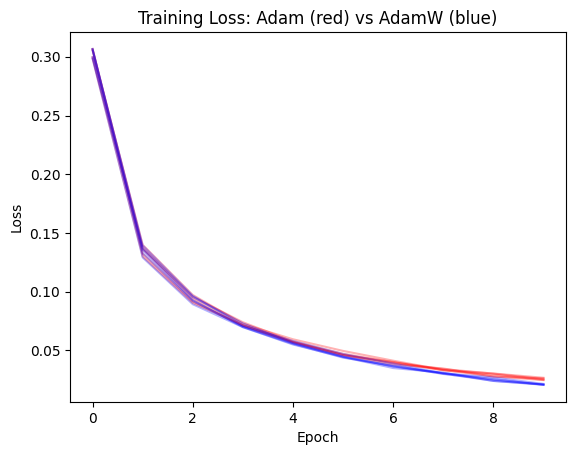

In [ ]:
# for losses, _ in adam_results:
#     plt.plot(losses, color='red', alpha=0.3)
# for losses, _ in adamw_results:
#     plt.plot(losses, color='blue', alpha=0.3)

# plt.title("Training Loss: Adam (red) vs AdamW (blue)")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.show()


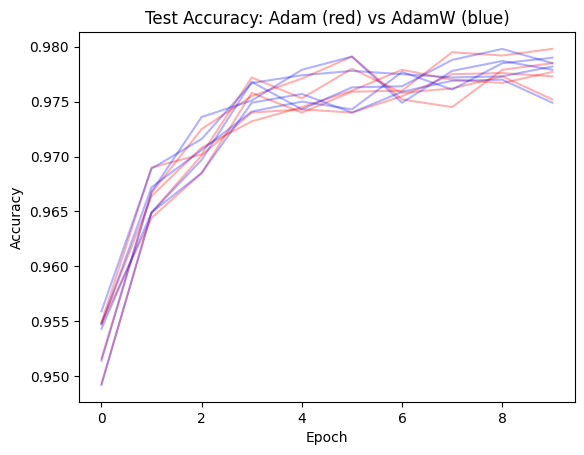

In [ ]:
# for _, accs in adam_results:
#     plt.plot(accs, color='red', alpha=0.3)
# for _, accs in adamw_results:
#     plt.plot(accs, color='blue', alpha=0.3)

# plt.title("Test Accuracy: Adam (red) vs AdamW (blue)")
# plt.xlabel("Epoch")
# plt.ylabel("Accuracy")
# plt.show()


In [ ]:
for r in adam_results:
    plt.plot(r["test_accuracy"], color="red", alpha=0.3)
for r in adamw_results:
    plt.plot(r["test_accuracy"], color="blue", alpha=0.3)
